In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib as il

from scipy.spatial.distance import cdist

from keras.utils import np_utils
from keras.layers import Conv2D, Dropout, Activation, LeakyReLU, MaxPooling2D, Flatten
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU

from scipy.spatial.distance import cdist

%matplotlib inline

/Users/josselinbonnevie/Applications/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


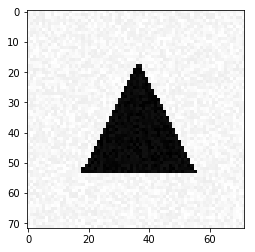

In [2]:
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
      #  if i % 10 == 0:
      #      print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
       # if i % 10 == 0:
        #    print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)


def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


def generate_dataset_denoising(nb_samples, noise=100):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,IMAGE_SIZE, IMAGE_SIZE,1])
    Y = np.zeros([nb_samples,IMAGE_SIZE, IMAGE_SIZE,1])
    print('Creating data:')
    for i in range(nb_samples):
      #  if i % 10 == 0:
      #      print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, True).reshape((IMAGE_SIZE, IMAGE_SIZE,1))
        elif category == 1: 
            Y[i] = generate_a_disk(0, True).reshape((IMAGE_SIZE, IMAGE_SIZE,1))
        else:
            Y[i] = generate_a_triangle(0, True)[0].reshape((IMAGE_SIZE, IMAGE_SIZE,1))
        NOISE = np.random.random(1)* noise 
        X[i] = Y[i] + NOISE * np.random.random(Y[i].shape)
        X[i] = (X[i] + NOISE) / (255 + 2 * NOISE)
    print(X.shape)
    print(Y.shape)
    Y = Y / 255 
    return [X, Y]

def generate_test_set_denoising(noise =100):
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_denoising(300, noise)
    return [X_test, Y_test]

In [2]:
[X_train1, Y_train1] = generate_dataset_classification(300, 20,)
[X_test1, Y_test1] = generate_dataset_classification(300, 20);

Creating data:
Creating data:


A function to display some data points

In [3]:
def display(X, Y, size, dic=None):
    plt.figure(figsize =(15,5))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.axis('off')
        if dic :
            plt.title(dic[int(Y[i])])
        else : 
            plt.title(int(Y[i]))
        plt.imshow(X[i].reshape((image_size, image_size)), cmap='gray')    

Let's copy the all the functions we need in the notebook

# III. Simple Classification :

In [28]:
image_size = IMAGE_SIZE

mu = X_train1.mean()
sigma = X_train1.std()

def prepare1(X, mu=mu, sigma=sigma, normalize = True):
    X = (X-mu)/sigma
    x = X.reshape(X.shape[0], image_size**2)
    return x

x_train1 = prepare1(X_train1)
x_test1 = prepare1(X_test1)
y_train1 = np_utils.to_categorical(Y_train1)

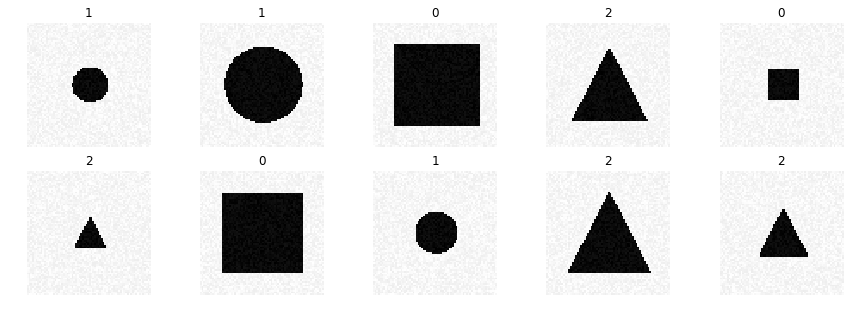

In [29]:
display(X_train1, Y_train1, image_size)

In [30]:
dic = {
    0 : 'rectangle',
    1: 'circle',
    2: 'triangle'
}

### With Stochastic gradient descent :

In [32]:
from keras.optimizers import SGD, Adam
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU

A linear classifier corresponds to a neural network with only one fully connected layer of 3 neurons, followed by a sigmoid activation. We used categorical_crossentropy loss.

In [71]:
N_units = 3

model1 = Sequential([
    Dense(N_units, activation = 'softmax', input_shape = (image_size**2,))])

In [72]:
opt = SGD(lr= 0.01,
         momentum = 0.4,
          decay = 1e-2,
          nesterov = True)

model1.compile(opt, loss = "categorical_crossentropy" , metrics = ['accuracy'])

In [51]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [52]:
model1.fit(x_train1, y_train1, epochs=30, batch_size=32, verbose = 1, validation_split=0.1)

Train on 270 samples, validate on 30 samples
Epoch 1/30
270/270 [==============================] - 0s 893us/step - loss: 2.7988 - acc: 0.5852 - val_loss: 2.0850 - val_acc: 0.5333
Epoch 2/30
270/270 [==============================] - 0s 92us/step - loss: 3.0142 - acc: 0.7037 - val_loss: 0.7711 - val_acc: 0.7667
Epoch 3/30
270/270 [==============================] - 0s 81us/step - loss: 2.0032 - acc: 0.7852 - val_loss: 0.3705 - val_acc: 0.7667
Epoch 4/30
270/270 [==============================] - 0s 88us/step - loss: 0.0634 - acc: 0.9815 - val_loss: 0.0613 - val_acc: 1.0000
Epoch 5/30
270/270 [==============================] - 0s 89us/step - loss: 0.0432 - acc: 0.9963 - val_loss: 0.0577 - val_acc: 1.0000
Epoch 6/30
270/270 [==============================] - 0s 86us/step - loss: 0.0344 - acc: 0.9963 - val_loss: 0.0714 - val_acc: 0.9667
Epoch 7/30
270/270 [==============================] - 0s 93us/step - loss: 0.0306 - acc: 1.0000 - val_loss: 0.0493 - val_acc: 1.0000
Epoch 8/30
270/270 [===

In [53]:
res = model1.evaluate(x_test1, np_utils.to_categorical(Y_test1), verbose=0);
print("Loss sur le test : ", res[0])
print("Accuracy sur le test : ", res[1])

Loss sur le test :  0.013607459540168444
Accuracy sur le test :  1.0


We get a perfect accuracy of 1.0 on the test data

Let's visualise the weights associated to each neurone (and thus to each class)

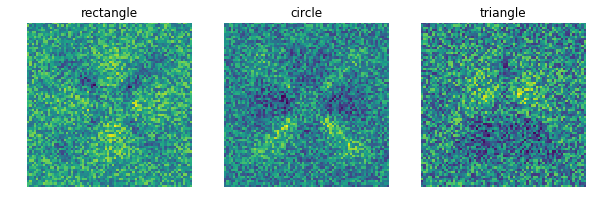

In [43]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(dic[i])
    plt.imshow(model1.get_weights()[0][:,i].reshape(image_size,image_size))

Affichons quelques exemples du jeu de test et les predictions associées :

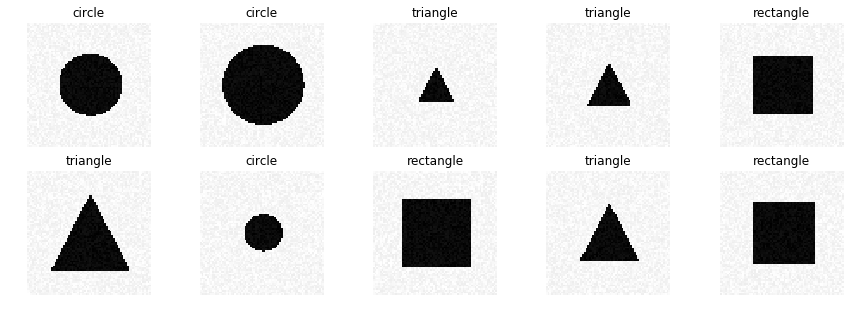

In [15]:
ypred_test1 = np.argmax(model1.predict(x_test1), axis = 1)
display(X_test1, ypred_test1, image_size, dic)

### With Adam

In [45]:
N_units = 3
image_size = IMAGE_SIZE

model2 = Sequential([
    Dense(N_units, activation = 'softmax', input_shape = (image_size**2,))])
opt = Adam(lr= 0.001, epsilon = 1e-6)

model2.compile(opt, loss = "categorical_crossentropy" , metrics = ['accuracy'])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 3)                 15555     
Total params: 15,555
Trainable params: 15,555
Non-trainable params: 0
_________________________________________________________________


In [46]:
model2.fit(x_train1, y_train1, epochs=30, batch_size=32, verbose = 1)

Epoch 1/30
300/300 [==============================] - 0s 760us/step - loss: 1.0238 - acc: 0.5700
Epoch 2/30
300/300 [==============================] - 0s 107us/step - loss: 0.3892 - acc: 0.8333
Epoch 3/30
300/300 [==============================] - 0s 84us/step - loss: 0.2022 - acc: 0.9667
Epoch 4/30
300/300 [==============================] - 0s 94us/step - loss: 0.1532 - acc: 0.9333
Epoch 5/30
300/300 [==============================] - 0s 95us/step - loss: 0.1351 - acc: 0.9467
Epoch 6/30
300/300 [==============================] - 0s 104us/step - loss: 0.0886 - acc: 0.9900
Epoch 7/30
300/300 [==============================] - 0s 111us/step - loss: 0.0744 - acc: 0.9900
Epoch 8/30
300/300 [==============================] - 0s 114us/step - loss: 0.0671 - acc: 0.9933
Epoch 9/30
300/300 [==============================] - 0s 94us/step - loss: 0.0578 - acc: 0.9967
Epoch 10/30
300/300 [==============================] - 0s 86us/step - loss: 0.0488 - acc: 1.0000
Epoch 11/30
300/300 [=============

Let's visualise the weights associated to each neurone (and thus to each class)

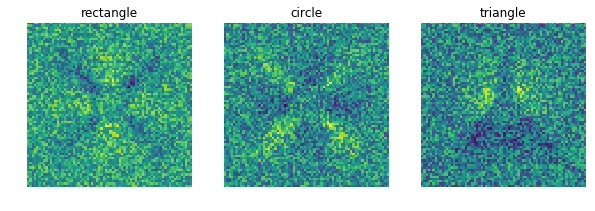

In [47]:
plt.figure(figsize=(10,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(dic[i])
    plt.imshow(model2.get_weights()[0][:,i].reshape(image_size,image_size))

In [48]:
res = model2.evaluate(x_test1, np_utils.to_categorical(Y_test1), verbose=0);
print("Loss sur le test : ", res[0])
print("Accuracy sur le test : ", res[1])

Loss sur le test :  0.00980292059481144
Accuracy sur le test :  1.0


We get a perfect accuracy of 1.0 on the test data.

SGD and ADAM seem quite similar for this problem. However finding a good value for the learning rate is easier with ADAM than with SGD.

# IV. A more difficult Classification Problem :  

In [5]:
[X_train2, Y_train2] = generate_dataset_classification(1000, 20, True)
[X_test2, Y_test2] = generate_test_set_classification()

Creating data:
Creating data:


In [6]:
mu2 = X_train2.mean()
sigma2 = X_train2.std()

x_train2 = prepare1(X_train2, mu = mu2, sigma=sigma2)
y_train2 = np_utils.to_categorical(Y_train2)
x_test2 = prepare1(X_test2, mu2, sigma2)
y_test2 = np.argmax(Y_test2, axis = 1)

NameError: name 'prepare1' is not defined

### Linear classifier :

In [63]:
N_units = 3

model3 = Sequential([
    Dense(N_units, activation = 'softmax', input_shape = (image_size**2,))])
opt = Adam(lr= 0.001, epsilon = 1e-6)

model3.compile(opt, loss = "categorical_crossentropy" , metrics = ['accuracy'])
model3.fit(x_train2, y_train2, epochs=50, batch_size=32, verbose = 1, validation_split= 0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/50
900/900 [==============================] - 0s 484us/step - loss: 1.0388 - acc: 0.5456 - val_loss: 0.9572 - val_acc: 0.4900
Epoch 2/50
900/900 [==============================] - 0s 82us/step - loss: 0.8477 - acc: 0.6400 - val_loss: 1.1306 - val_acc: 0.5800
Epoch 3/50
900/900 [==============================] - 0s 85us/step - loss: 0.7252 - acc: 0.6811 - val_loss: 0.9514 - val_acc: 0.5900
Epoch 4/50
900/900 [==============================] - 0s 87us/step - loss: 0.5885 - acc: 0.7411 - val_loss: 1.0668 - val_acc: 0.4700
Epoch 5/50
900/900 [==============================] - 0s 93us/step - loss: 0.5422 - acc: 0.7644 - val_loss: 1.1139 - val_acc: 0.4600
Epoch 6/50
900/900 [==============================] - 0s 91us/step - loss: 0.5215 - acc: 0.7600 - val_loss: 1.1233 - val_acc: 0.5400
Epoch 7/50
900/900 [==============================] - 0s 91us/step - loss: 0.4648 - acc: 0.8178 - val_loss: 1.1243 - val_acc: 0.4900
Epoch 8/50
900/900 [==

In [59]:
res = model3.evaluate(x_test2, Y_test2, verbose=0);
print("Loss sur le test : ", res[0])
print("Accuracy sur le test : ", res[1])

Loss sur le test :  1.4846795638402304
Accuracy sur le test :  0.5899999992052714


In this case there is no invariance to translation built into the network. So the network overfits. The accuracy on the training data goes to 1 but it stays below 0.6 on the validation and test data.

Let's have a look at the learned weights

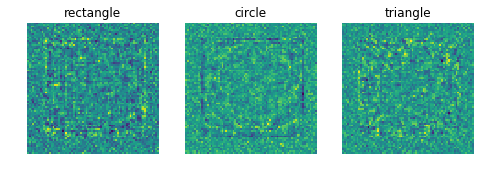

In [64]:
plt.figure(figsize=(8,4))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.title(dic[i])
    plt.imshow(model3.get_weights()[0][:,i].reshape(image_size,image_size))

Let's have a look at a few data points and the corresponding predictions made by the network.

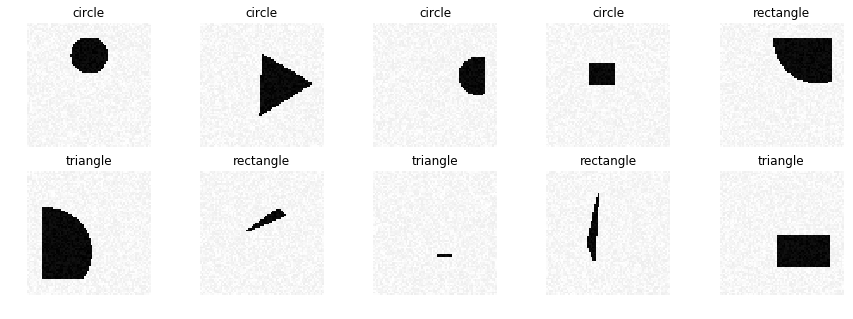

In [26]:
ypred_test2 = np.argmax(model2.predict(x_test2), axis = 1)
display(X_test2, ypred_test2, image_size, dic)

The predictions are realy bad

### Convolutional Network :

In [31]:
def prepare2(X, mu=mu2, sigma=sigma2, normalize = True):
    if normalize : 
        X = (X - mu)/sigma
    X = X.reshape(X.shape[0], image_size, image_size,1)
    return X

In [67]:
x_train2conv = prepare2(X_train2, normalize=True)
x_test2conv = prepare2(X_test2, normalize=True)
print(x_train2conv.shape)

(1000, 72, 72, 1)


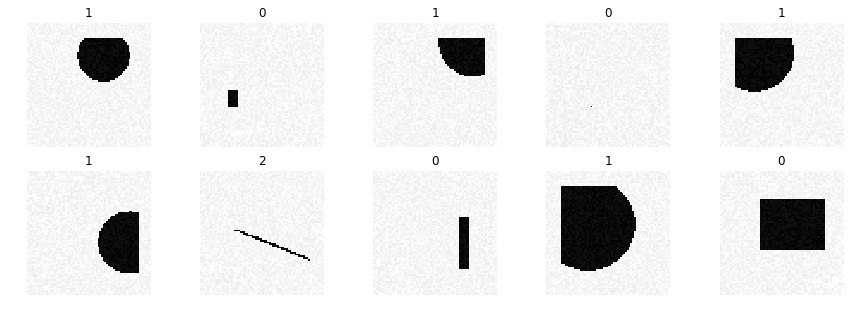

In [69]:
display(X_train2, Y_train2, image_size)

We use a classical convolutionnal model : one convolutionnal layer (followed by a leaky Relu and MaxPooling layer) and one fully connected layer (followed by a sigmoid activation).

In [74]:
IS = image_size

Mconv1 = Sequential()

Mconv1.add(Conv2D(16, kernel_size= (5,5), input_shape = (IS, IS,1),use_bias=True))
Mconv1.add(Activation('relu'))
print(Mconv1.output.shape)
Mconv1.add(MaxPooling2D(pool_size=(64,64)))
print(Mconv1.output.shape)
Mconv1.add(Flatten())
Mconv1.add(Dense(3,use_bias=True))
Mconv1.add(Activation('softmax'))
print(Mconv1.output.shape)

Mconv1.summary()

(?, 68, 68, 16)
(?, 1, 1, 16)
(?, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 68, 68, 16)        416       
_________________________________________________________________
activation_1 (Activation)    (None, 68, 68, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 51        
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total params: 467
Trainable params: 467
Non-trainable params: 0
_________________________________________

In [75]:
opt = Adam(lr = 0.001)
Mconv1.compile(opt, loss = "categorical_crossentropy" , metrics = ['accuracy'])

In [76]:
Mconv1.fit(x_train2conv, y_train2, epochs= 20, batch_size=32)

Epoch 1/20
1000/1000 [==============================] - 2s 2ms/step - loss: 1.0160 - acc: 0.5560
Epoch 2/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.8261 - acc: 0.8330
Epoch 3/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.7236 - acc: 0.8850
Epoch 4/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.6323 - acc: 0.9500
Epoch 5/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.5517 - acc: 0.9420
Epoch 6/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4763 - acc: 0.9660
Epoch 7/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.4084 - acc: 0.9800
Epoch 8/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.3504 - acc: 0.9800
Epoch 9/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2977 - acc: 0.9870
Epoch 10/20
1000/1000 [==============================] - 2s 2ms/step - loss: 0.2608 - acc: 0.9860
Epoch 11/20
1000/1000 [======

We evaluate the model on the test data

In [78]:
res = Mconv1.evaluate(x_test2conv, Y_test2, verbose=0);
print("Loss sur le test : ", res[0])
print("Accuracy sur le test : ", res[1])

Loss sur le test :  0.09386903901894887
Accuracy sur le test :  0.9866666674613953


The accuracy is very close to one, however it is no longer perfect.

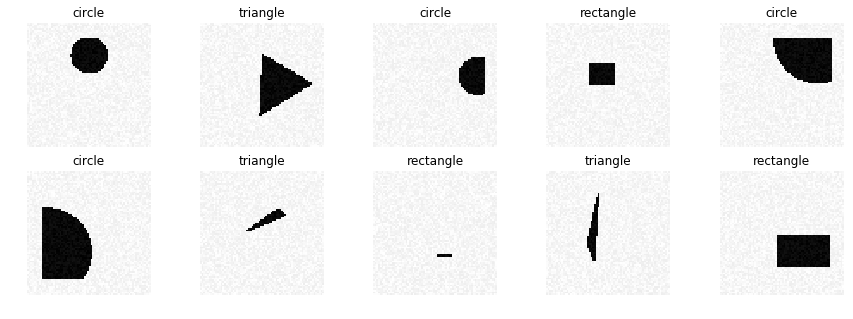

In [79]:
ypred_test2 = np.argmax(Mconv1.predict(x_test2conv), axis =1)
display(X_test2, ypred_test2, image_size, dic)

Let's have a look at data points where the model makes errors


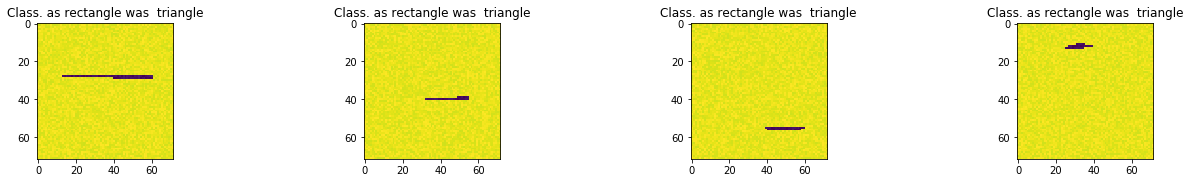

In [80]:
p = np.argmax(Mconv1.predict(x_test2conv), axis = 1)
ind =np.argwhere(p != np.argmax(Y_test2,axis=1))[:,0]
errors = x_test2conv[ind]

print("Let's have a look at data points where the model makes errors")
N = ind.shape[0]
plt.figure(figsize = (20,5))
for n in range(N):
    plt.subplot(1,2*N-1,n*2+1)
    plt.imshow(errors[n,:,:,0])
    plt.title("Class. as " + dic[p[ind[n]]] + " was  " + dic[y_test2[ind[n]]])

The only errors are for very very flat triangles that are classified as rectangles. But those were actually almost unclassifiable by the human eye so we can be satisfied with this behaviour.

# VI. A regression problem :

In [19]:
import tensorflow as tf
import keras.backend as K

Creating a dataset :

In [20]:
[X_train3, Y_train3] = generate_dataset_regression(2000, 20)

Creating data:


In [21]:
[X_test3, Y_test3] = generate_test_set_regression()

Creating data:


In [32]:
mu3 = X_train3.mean()
sigma3 = X_train3.mean()
x_train3 = prepare2(X_train3, mu3, sigma3, normalize=False)
x_test3 = prepare2(X_test3, mu3, sigma3, normalize= False)

Let's visualize and exemple of a data point

[0.16408787 0.22019863 0.86675573 0.17540465 0.55328695 0.40883651]


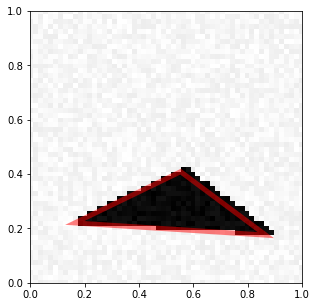

In [33]:
n = 2
visualize_prediction(X_train3[n],Y_train3[n])
print(Y_train3[n])

## X-Ordering of the coordinates :

We want to regress to the coordinate of the three vertices of triangles. However we have a problem : there is no unique way to order those coordinate. 

Thus we have to find a way to represent those coordinates in a unique manner. I chose to first try and order them by increasing first coordinate x.

To help the network, we also add to the raw image data, 2 channels corresponding each to the x coordinate and y coordinate of each pixel.

In [102]:
def xorder(Y):
    ind2 = np.argsort(Y[:, [0,2,4]], axis = 1)
    ind2 = ind2.repeat(2, axis = 1)*2.0
    Z=np.zeros(Y.shape[0])
    O=np.ones(Y.shape[0])
    dec = np.c_[np.c_[Z,O,Z,O,Z,O]]
    ind2 += dec
    ind1 = np.repeat(np.array(range(Y.shape[0])).reshape((Y.shape[0],1)), 6, axis =1)
    res = Y[ind1,ind2.astype(int)]
    return res

Yntr1 = xorder(Y_train3)
Ynte = xorder(Y_test3)

In [103]:
def addcoord(X):
    N = X.shape[0]
    meshx , meshy = np.meshgrid(np.linspace(0,1,num = image_size),np.linspace(0,1,num = image_size))
    trainm = np.zeros((N,image_size, image_size,3))
    for i in range(N):
        trainm[i, :, :,0]= X[i,:,:,0]
        trainm[i, :, :, 1]=meshx
        trainm[i, :, :, 2]=meshy
    return trainm

In [104]:
x_train3ac = addcoord(x_train3)
x_test3ac = addcoord(x_test3)

We use a convolutionnal model with several fully Convolutionnal layers followed my a few fully connected layers.

In [109]:
MMM = Sequential()

MMM.add(Conv2D(16, kernel_size = (7,7), input_shape= (image_size,image_size,3), padding = 'same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Conv2D(16*4, kernel_size = (5,5), padding='same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Conv2D(16*4, kernel_size = (3,3), padding='same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Conv2D(16*8, kernel_size = (3,3), padding='same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Conv2D(16*16, kernel_size = (3,3), padding='same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Conv2D(16*16*2, kernel_size = (3,3), padding='same'))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(MaxPooling2D(pool_size=(2,2)))
print(MMM.output.shape)

MMM.add(Flatten())
MMM.add(Dense(30))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(Dense(30))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(Dense(30))
MMM.add(LeakyReLU(alpha=0.1))
MMM.add(Dense(3*2))
MMM.add(Activation('sigmoid'))

(?, 36, 36, 16)
(?, 18, 18, 64)
(?, 9, 9, 64)
(?, 4, 4, 128)
(?, 2, 2, 256)
(?, 1, 1, 512)


In [110]:
opt = Adam(lr = 0.001)
MMM.compile(opt, "MSE")

MMM.fit(x_train3ac, Yntr1 ,epochs = 25, batch_size = 32, validation_split = 0.05)

Train on 1900 samples, validate on 100 samples
Epoch 1/100
1900/1900 [==============================] - 32s 17ms/step - loss: 0.2177 - val_loss: 0.1914
Epoch 2/100
1900/1900 [==============================] - 33s 18ms/step - loss: 0.1574 - val_loss: 0.1345
Epoch 3/100
1900/1900 [==============================] - 31s 16ms/step - loss: 0.1226 - val_loss: 0.1112
Epoch 4/100
1900/1900 [==============================] - 35s 19ms/step - loss: 0.1015 - val_loss: 0.0998
Epoch 5/100
1900/1900 [==============================] - 36s 19ms/step - loss: 0.0872 - val_loss: 0.0915
Epoch 6/100
1900/1900 [==============================] - 39s 21ms/step - loss: 0.0763 - val_loss: 0.0774
Epoch 7/100
1900/1900 [==============================] - 31s 16ms/step - loss: 0.0679 - val_loss: 0.0651
Epoch 8/100
1900/1900 [==============================] - 32s 17ms/step - loss: 0.0587 - val_loss: 0.0675
Epoch 9/100
1900/1900 [==============================] - 31s 17ms/step - loss: 0.0551 - val_loss: 0.0563
Epoch 10

KeyboardInterrupt: 

Let's visualize the results :

In [113]:
pred = MMM.predict(x_test3ac)
predt = MMM.predict(x_train3ac[:300])

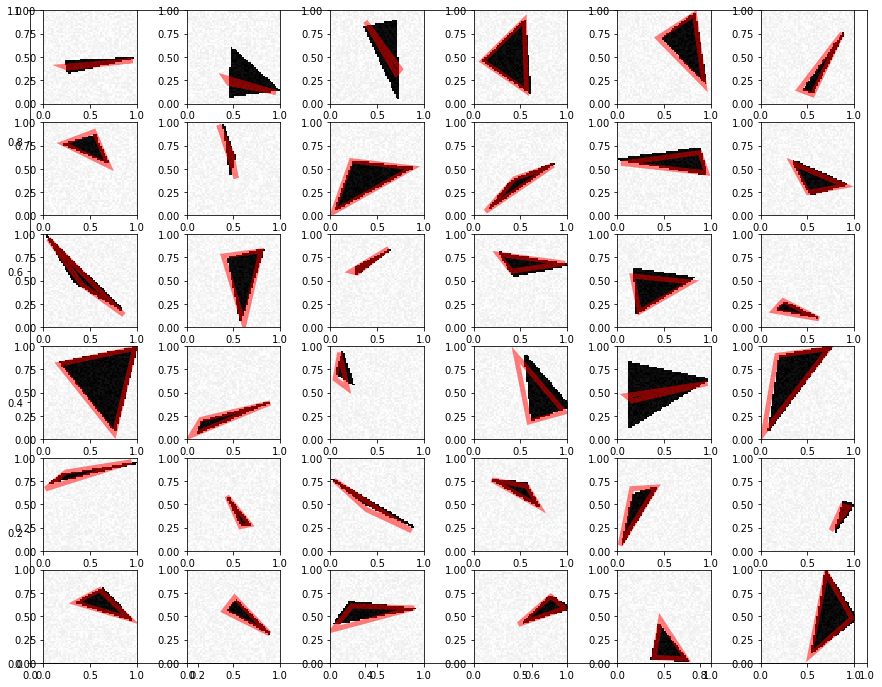

In [119]:
fig, ax = plt.subplots(figsize=(15,12))
base = 20
nomb = 6

for i in range(nomb**2):
    x = X_test3[i+base]
    y = pred[i+base]
    ax = fig.add_subplot(nomb,nomb,i+1)
    I = x.reshape((image_size,image_size))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

This method performs quite well as long as all vertices of the triangle have rather distinct x coordinates. We can see that the model makes mistakes when two vertices are above one another.

## Chamfer distance : 

Instead of finding an optimal way to order the coordinates, we try to use a modified loss : the Chamfer distance. This loss is used in 3D modeling to learn the matching of point clouds in a 3D space.

Given a distance $d(.,.)$, we define the Chamfer distance between two sets of points P_1 et P_2 : 


$CD(P_1, P_2) =\frac{1}{N_1 + N_2} \sum_{p_1 \in P_1} \min_{p_2 \in P_2} d(p_1, p_2)  + \sum_{p_2 \in P_2} \min_{p_1 \in P_1} d(p_1, p_2) $

The fact that we sum over $P_1$ and then $P_2$ prevents the collapsing of all points of one group to only one point of the other group.

I used a Euclidian distance for d (I actualy used a slightly modified version, summing  he $d^2$ and taking the square root of the final average)£

In [124]:
MMM2 = Sequential()

MMM2.add(Conv2D(16, kernel_size = (7,7), input_shape= (image_size,image_size,3), padding = 'same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Conv2D(16*4, kernel_size = (5,5), padding='same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Conv2D(16*4, kernel_size = (3,3), padding='same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Conv2D(16*8, kernel_size = (3,3), padding='same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Conv2D(16*16, kernel_size = (3,3), padding='same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Conv2D(16*16*2, kernel_size = (3,3), padding='same'))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(MaxPooling2D(pool_size=(2,2)))
print(MMM2.output.shape)

MMM2.add(Flatten())
MMM2.add(Dense(30))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(Dense(30))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(Dense(30))
MMM2.add(LeakyReLU(alpha=0.1))
MMM2.add(Dense(3*2))
MMM2.add(Activation('sigmoid'))

(?, 36, 36, 16)
(?, 18, 18, 64)
(?, 9, 9, 64)
(?, 4, 4, 128)
(?, 2, 2, 256)
(?, 1, 1, 512)


In [146]:
#Loss used for backprogpagation
def chamfer_loss_1(y_true, y_pred):           
    E = K.reshape(y_true, (-1,3,2,1))
    F = K.reshape(y_pred, (-1,3,2,1))
    F = K.permute_dimensions(F, (0,3,2,1))

    t = E - F 
    dist = K.square(tf.norm(t, ord='euclidean', axis = 2))
    d1 = K.mean(K.min(dist, axis = 1), axis = 1)
    d2 = K.mean(K.min(dist, axis = 2), axis = 1)
    finalChamferDistanceSum = K.sqrt((d1 + d2)/2)
    return finalChamferDistanceSum

In [497]:
#Actual proper Chamfer loss for euclidean distance
def chamfer_loss_value(y_true, y_pred):           

    E = K.reshape(y_true, (-1,3,2,1))
    F = K.reshape(y_pred, (-1,3,2,1))
    F = K.permute_dimensions(F, (0,3,2,1))

    t = E - F 
    dist = tf.norm(t, ord='euclidean', axis = 2)
    d1 = K.mean(K.min(dist, axis = 1), axis = 1)
    d2 = K.mean(K.min(dist, axis = 2), axis = 1)
    finalChamferDistanceSum = (d1 + d2)/2
    return finalChamferDistanceSum

In [147]:
opt = Adam(lr = 0.001)
MMM2.compile(opt, chamfer_loss_1, metrics=[chamfer_loss_value])

MMM2.fit(x_train3ac, Y_train3 ,epochs = 13, batch_size = 32, validation_split = 0.05)

Train on 1900 samples, validate on 100 samples
Epoch 1/100
1900/1900 [==============================] - 33s 18ms/step - loss: 0.0612 - chamfer_loss_value: 0.0531 - val_loss: 0.0752 - val_chamfer_loss_value: 0.0645
Epoch 2/100
1900/1900 [==============================] - 36s 19ms/step - loss: 0.0530 - chamfer_loss_value: 0.0464 - val_loss: 0.0701 - val_chamfer_loss_value: 0.0589
Epoch 3/100
1900/1900 [==============================] - 31s 16ms/step - loss: 0.0499 - chamfer_loss_value: 0.0434 - val_loss: 0.0690 - val_chamfer_loss_value: 0.0587
Epoch 4/100
1900/1900 [==============================] - 31s 16ms/step - loss: 0.0501 - chamfer_loss_value: 0.0433 - val_loss: 0.0678 - val_chamfer_loss_value: 0.0593
Epoch 5/100
1900/1900 [==============================] - 31s 17ms/step - loss: 0.0470 - chamfer_loss_value: 0.0408 - val_loss: 0.0654 - val_chamfer_loss_value: 0.0552
Epoch 6/100
1900/1900 [==============================] - 34s 18ms/step - loss: 0.0449 - chamfer_loss_value: 0.0391 - v

KeyboardInterrupt: 

In [148]:
opt = Adam(lr = 0.0001)
MMM2.compile(opt, chamfer_loss_1, metrics=[chamfer_loss_value])

MMM2.fit(x_train3ac, Y_train3, epochs = 10, batch_size = 32, validation_split = 0.05)

Train on 1900 samples, validate on 100 samples
Epoch 1/10
1900/1900 [==============================] - 34s 18ms/step - loss: 0.0294 - chamfer_loss_value: 0.0253 - val_loss: 0.0548 - val_chamfer_loss_value: 0.0450
Epoch 2/10
1900/1900 [==============================] - 31s 16ms/step - loss: 0.0254 - chamfer_loss_value: 0.0218 - val_loss: 0.0542 - val_chamfer_loss_value: 0.0443
Epoch 3/10
1900/1900 [==============================] - 32s 17ms/step - loss: 0.0240 - chamfer_loss_value: 0.0205 - val_loss: 0.0555 - val_chamfer_loss_value: 0.0452
Epoch 4/10
1900/1900 [==============================] - 31s 16ms/step - loss: 0.0229 - chamfer_loss_value: 0.0195 - val_loss: 0.0537 - val_chamfer_loss_value: 0.0437
Epoch 5/10
1900/1900 [==============================] - 38s 20ms/step - loss: 0.0220 - chamfer_loss_value: 0.0186 - val_loss: 0.0534 - val_chamfer_loss_value: 0.0435
Epoch 6/10
1900/1900 [==============================] - 40s 21ms/step - loss: 0.0214 - chamfer_loss_value: 0.0181 - val_los

KeyboardInterrupt: 

In [149]:
predchaf = MMM2.predict(x_test3ac)
#predtchaf = MMM2.predict(x_train3ac[:300])

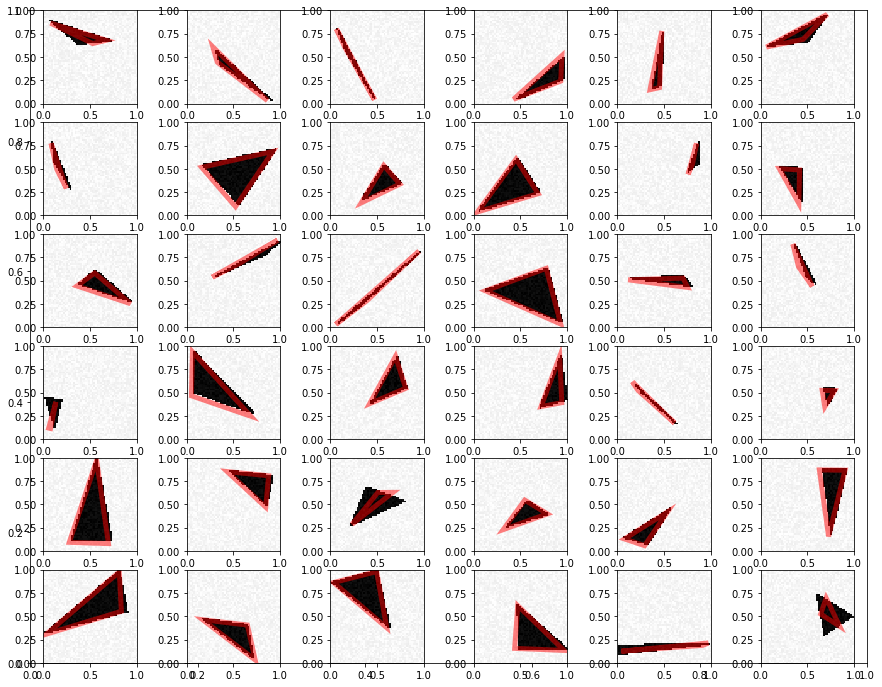

In [151]:
fig, ax = plt.subplots(figsize=(15,12))
base = 60
nomb = 6

for i in range(nomb**2):
    x = X_test3[i+base]
    y = predchaf[i+base]
    ax = fig.add_subplot(nomb,nomb,i+1)
    I = x.reshape((image_size,image_size))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

The results are overall much metter, even when some vertices have similar x coordinates or y coordinates. However there are still a few cases where the algorithm misses completely. Especially with small triangles.

## Not fully differentiable approach : (doesn't work anymore, haven't touched it in a while and didn't have time to make it work again, used to work perfectly)

This wasn't exactly what was asked but i tried this method so I'm still exposing it here. I tried to produce a heatmap that would localise the vertices and then i manualy extracted local minimas.

First I define a gaussian kernel that i will convolve with the ground truth coordinates of the vertices to get a groud truce heatmap.

In [141]:
x_train3bis = prepare2(X_train3, mu3, sigma3, normalize=True)
x_test3bis = prepare2(X_test3, mu3, sigma3, normalize= True)

In [142]:
NK = 11
image_size = 72

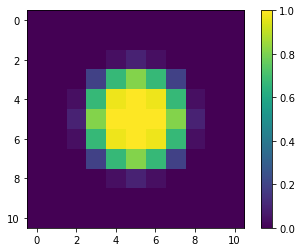

In [339]:
x = np.linspace(-1,1,num =NK)
y = np.linspace(-1,1,num =NK)
x,y = np.meshgrid(x,y)
s = 0.1
gs = np.exp(-0.5 * (x**2 + y**2)**3/s**2)
gs = gs/ np.max(gs)
plt.imshow(gs)
plt.colorbar()
gs = gs.reshape(NK,NK,1,1)

In [340]:
M = Sequential([
    Conv2D(1, kernel_size= (NK,NK), input_shape = (image_size, image_size,1), use_bias=False,padding='same')
])
M.compile('adam', 'categorical_crossentropy')
M.layers[0].set_weights([gs])

In [341]:
def punctual_heatmap(Y, isize = image_size, blur = True, kern = M):
    N= Y.shape[0]
    HM = np.zeros((N,image_size, image_size,1))
    YY = (Y.reshape(N,3,2) - 0.5)/1.3 + 0.5
    for i in range(N):
        for j in range(3):
            HM[i, int((1-YY[i,j,1])*isize), int(YY[i,j,0]*isize),0]=1
    if blur :
        HM = M.predict(HM)
    return HM

In [342]:
Y3hm = punctual_heatmap(Y_train3, blur=True)
Y3hm = Y3hm

We can visualize the target heatmaps.

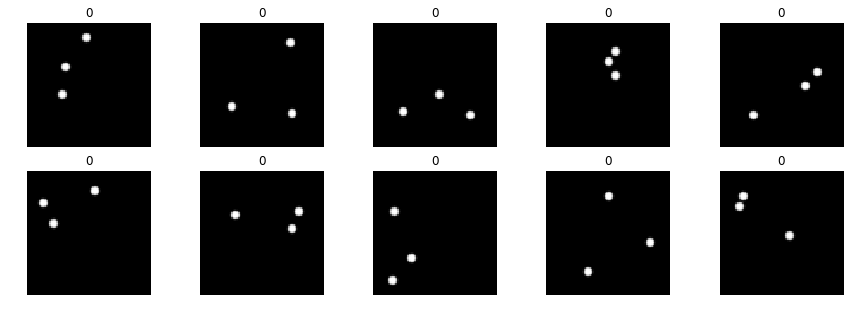

In [343]:
display(Y3hm, Y_train3[:,0], 72)

In [344]:
y_train3 = Y_train3.reshape((-1,3,2))

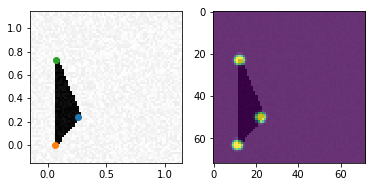

In [345]:
plt.subplot(1,2,1)

plt.imshow( x_train3[n,:,:,0],extent=[-0.15,1.15,-0.15,1.15], cmap = 'gray')
#plt.imshow( x_train3[n,:,:,0], cmap = 'gray')

for j in range(3):
    #plt.scatter(y_train3[n,j,0]* image_size, (1-y_train3[n,j,1])*image_size)
    plt.scatter(y_train3[n,j,0], y_train3[n,j,1])
    
plt.subplot(1,2,2)
plt.imshow(x_train3[n,:,:,0], cmap = 'gray')
plt.imshow(Y3hm[n,:,:,0], alpha = 0.8)
n+=1

With a simple convolutionnal model without any pooling we produce a heatmap. I used a binary crossentropy loss

In [347]:
MM = Sequential()
MM.add(Conv2D(32, kernel_size = (5,5), input_shape= (image_size,image_size,1), padding='same'))
MM.add(LeakyReLU(alpha=0.05))
print(MM.output.shape)
MM.add(Conv2D(32, kernel_size = (5,5), padding='same'))
MM.add(LeakyReLU(alpha=0.05))
print(MM.output.shape)
MM.add(Conv2D(32, kernel_size = (3,3), padding='same'))
MM.add(LeakyReLU(alpha=0.05))
print(MM.output.shape)
MM.add(Conv2D(1, kernel_size = (1,1), padding='same'))
MM.add(Activation('sigmoid'))

print(MM.output.shape)

MM.summary()

(?, 72, 72, 32)
(?, 72, 72, 32)
(?, 72, 72, 32)
(?, 72, 72, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_74 (Conv2D)           (None, 72, 72, 32)        832       
_________________________________________________________________
leaky_re_lu_49 (LeakyReLU)   (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 72, 72, 32)        25632     
_________________________________________________________________
leaky_re_lu_50 (LeakyReLU)   (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
leaky_re_lu_51 (LeakyReLU)   (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_77 (Co

In [370]:
opt = Adam(lr = 0.0001)
MM.compile(opt, 'binary_crossentropy')

MM.fit(x_train3bis, Y3hm, epochs = 30, batch_size = 32, validation_split = 0.05)

Train on 1900 samples, validate on 100 samples
Epoch 1/30
1900/1900 [==============================] - 59s 31ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 2/30
  32/1900 [..............................] - ETA: 54s - loss: 0.0127

KeyboardInterrupt: 

In [450]:
pred3t = MM.predict(x_test3bis[:10])

In [451]:
x_train3.max()

0.9999999943631133

Here we can observe the predicted heatmap for one triangle of the test set

In [503]:
n=0

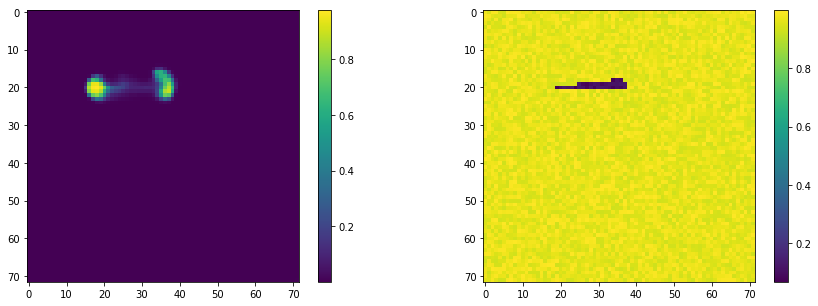

In [454]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(pred3t[n,:,:,0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(x_test3[n,:,:,0])
plt.colorbar()
n+=1

We predict by finding the coordinates of the maximum of the heatmap, then substract a gaussian stain at this location of the heatmap so that it is no longer a maximum and we look for the next local maximum.

In [479]:
pred3test = MM.predict(x_test3bis)

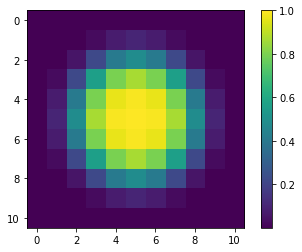

In [464]:
x = np.linspace(-1,1,num =NK)
y = np.linspace(-1,1,num =NK)
x,y = np.meshgrid(x,y)
s = 0.3
gs = np.exp(-0.5 * (x**2 + y**2)**2/s**2)
gs = gs/ np.max(gs)
plt.imshow(gs)
plt.colorbar()
gs = gs.reshape(NK,NK,1,1)

In [465]:
Mp = Sequential([
    Conv2D(1, kernel_size= (NK,NK), input_shape = (image_size, image_size,1), use_bias=False,padding='same')
])
Mp.compile(opt, 'categorical_crossentropy')
Mp.layers[0].set_weights([gs])

In [510]:
def error(res, ver):
    dist = cdist(ver, res)
    err = 0
    for k in range(3):
        i = np.argmin(dist[k])
        err += dist[k,i]
        dist = np.delete(dist, i, axis = 1)
    return(err)

In [514]:
def Chamfer_error_numpy(res, ver):
    dist = cdist(ver, res)
    err = np.min(dist, axis = 0).sum() + np.min(dist, axis = 1).sum()
    return(err/6)

The following plots illustrate how i recursively find the maximum, substract a gaussian stain at that point, and then find a second maximum, substract a gaussian stain at that point and finaly find a third maximum. 
On the last plot you can see the predicted vertices as red dots and the predicted vertices as black crosses.

In [539]:
n = -1

Chamfer error :
0.013888888888888895


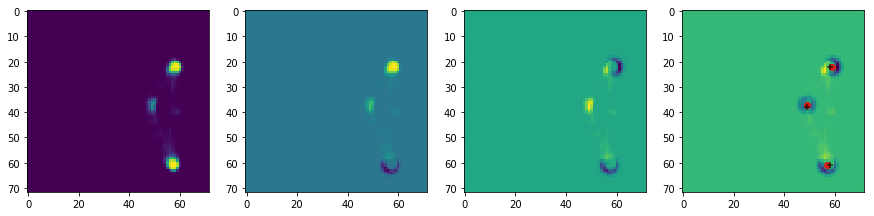

In [545]:
n+=1


ppp = pred3test[n,:,:,0]

ver = np.round(((Y_test3[n]-0.5)/1.3 + 0.5)* image_size).reshape((3,2))
#print(ver)

plt.figure(figsize = (15,5))

res = np.zeros((3,2))
plt.subplot(1,4,1)
plt.imshow(ppp)
for k in range(3):
    plt.subplot(1,4, 2+k)
    I = np.zeros((image_size, image_size)).reshape((1,image_size, image_size, 1))
    maxi = np.unravel_index(np.argmax(ppp), dims = (image_size, image_size))
  #  print(maxi[1], image_size-maxi[0])
    res[k] = [maxi[1], image_size - maxi[0]]
    I[0, maxi[0], maxi[1],0] = ppp.max()
    I = Mp.predict(I)
    ppp =ppp - I[0,:,:,0]
    plt.imshow(ppp)
plt.scatter(res[:,0],  image_size -res[:,1], alpha = 0.8, c = 'red')
plt.scatter(ver[:,0],  image_size -ver[:,1], alpha = 0.7, c = 'black', marker ='+')
print("Chamfer error :")
print(Chamfer_error_numpy(res/72, ver/72))

In [654]:
Nt = X_test3.shape[0]
errors = np.zeros(Nt)
pred3_fin = np.zeros((Nt,3,2))
for n in range(Nt):
    ppp = pred3test[n,:,:,0]
    ver = np.round(((Y_test3[n]-0.5)/1.3 + 0.5)* image_size).reshape((3,2))
    res = np.zeros((3,2))
    for k in range(3):
        I = np.zeros((image_size, image_size)).reshape((1,image_size, image_size, 1))
        maxi = np.unravel_index(np.argmax(ppp), dims = (image_size, image_size))
        res[k] = [maxi[1], image_size - maxi[0]]
        I[0, maxi[0], maxi[1],0] = ppp.max()
        I = Mp.predict(I)
        ppp =ppp - I[0,:,:,0]
    pred3_fin[n] = ((res)/72 - 0.5) * 1.30 + 0.5
    errors[n]= Chamfer_error_numpy((res/72 - 0.5) /0.75 +0.5, (ver/72 - 0.5) /0.75 +0.5)

The mean Chamfer Error on the test set : 

In [655]:
errors.mean()

0.022926305764863673

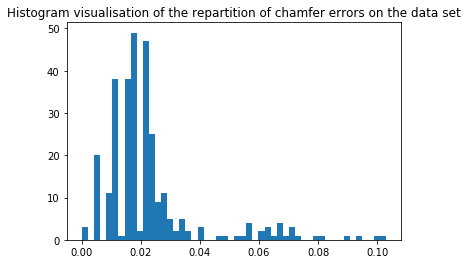

In [656]:
plt.hist(errors, bins=50);
plt.title("Histogram visualisation of the repartition of chamfer errors on the data set")

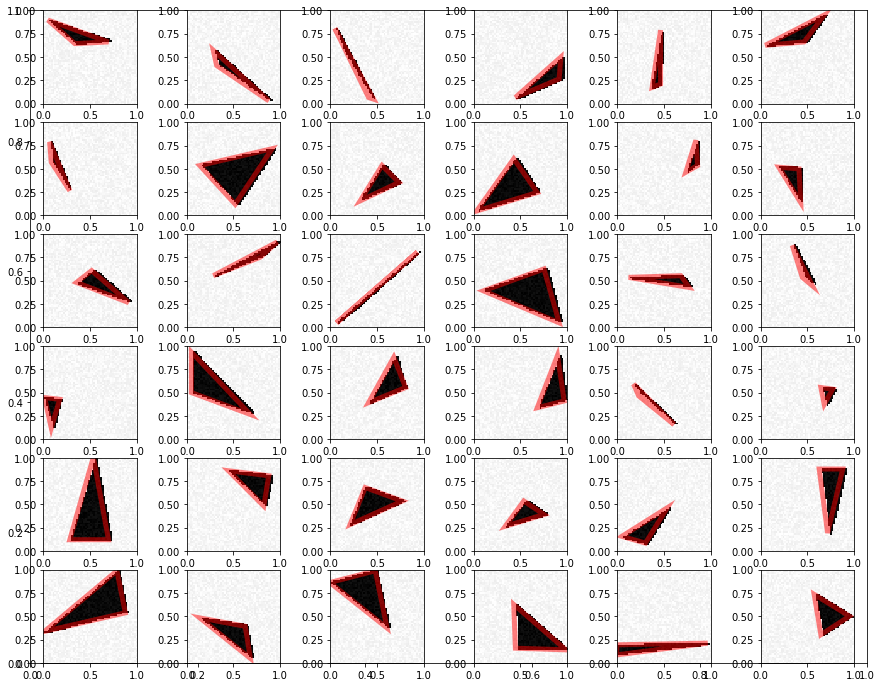

In [657]:
fig, ax = plt.subplots(figsize=(15,12))
base = 60
nomb = 6

for i in range(nomb**2):
    x = X_test3[i+base]
    y = pred3_fin[i+base]
    ax = fig.add_subplot(nomb,nomb,i+1)
    I = x.reshape((image_size,image_size))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

This method actually brings the best results. However I restarted the notebook in between and didn't have time to retrain it so I can't compare one unique metric on all losses.

# 7. Image denoising :

In [3]:
image_size  = 72

In [4]:
[X_train7, Y_train7] = generate_dataset_denoising(1000, 300)
[X_test7, Y_test7] = generate_dataset_denoising(300, 300);

Creating data:
(1000, 72, 72, 1)
(1000, 72, 72, 1)
Creating data:
(300, 72, 72, 1)
(300, 72, 72, 1)


We generated images with uniform noise. The amplitude of the noise varies from one image to an other. Let's have a look at some of the data points.

In [5]:
def display_denoising(X, Y, offset = 0):
    plt.figure(figsize =(15,5))
    for i in range(5):
        plt.subplot(2,5,i+1)
        plt.axis('off')
        plt.imshow(X[offset + i].reshape((image_size, image_size)), cmap='gray')
        plt.subplot(2,5,i+6)
        plt.imshow(Y[offset + i].reshape((image_size, image_size)), cmap='gray')

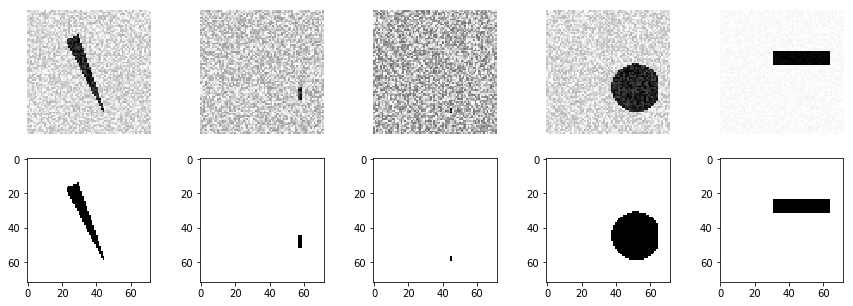

In [6]:
display_denoising(X_train7, Y_train7)

In [7]:
from keras import Input, Model
from keras.layers import UpSampling2D, merge
from keras.optimizers import Adam

I use a rather classical U-net structure and the mean absolute error.

In [12]:
i = Input(shape = (image_size, image_size,1))

conv1a = Conv2D(16, 7, padding='same')(i)
conv1ra = LeakyReLU(alpha = 0.1)(conv1a)
conv1b = Conv2D(32, 3, padding='same')(conv1ra)
conv1rb = LeakyReLU(alpha = 0.1)(conv1b)
pool1b = MaxPooling2D(pool_size=(2,2))(conv1rb)

conv2 = Conv2D(32, 3, padding='same')(pool1b)
conv2r = LeakyReLU(alpha = 0.05)(conv2)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2r)

conv3 = Conv2D(48, 3, padding='same')(pool2)
conv3r = LeakyReLU(alpha=0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3r)

conv4 = Conv2D(64, 3, padding = 'same')(pool3)
conv4r = LeakyReLU(alpha=0.1)(conv4)

up3 = UpSampling2D(size = (2,2))(conv4r)
up_conv3 = Conv2D(64, 3, padding='same')(up3)
up_conv3r = LeakyReLU(alpha = 0.1)(up_conv3)

up2 = UpSampling2D(size = (2,2))(up_conv3r)
up_conv2 = Conv2D(48, 3, padding='same')(up2)
up_conv2r = LeakyReLU(alpha = 0.1)(up_conv2)
merge2 = merge([conv2r,up_conv2r], mode = 'concat', concat_axis=3)


up1 = UpSampling2D(size =(2,2))(merge2)
up_conv1 = Conv2D(48, 3, padding='same')(up1)
up_conv1r = LeakyReLU(alpha = 0.1)(up_conv1)
merge1 = merge([conv1rb,up_conv1r], mode = 'concat',concat_axis=3)

pre1 = Conv2D(32, 3, padding='same')(merge1)
pre1r = LeakyReLU(alpha=0.1)(pre1)
pre2 = Conv2D(32, 3, padding='same')(pre1r)
pre2r =  LeakyReLU(alpha=0.1)(pre2)
#pre3 = Conv2D(filters = 64, kernel_size=1, padding='same')(pre2r)
#pre3r = LeakyReLU(alpha=0.1)(pre3)
output = Conv2D(filters = 1, kernel_size=3, padding='same')(pre2r)


model = Model(input = i, output = output)
print(model.output.shape)

(?, 72, 72, 1)


/Users/josselinbonnevie/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/josselinbonnevie/Applications/anaconda/lib/python3.6/site-packages/keras/legacy/layers.py:465: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/Users/josselinbonnevie/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:33: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/Users/josselinbonnevie/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:44: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co

In [13]:
model.compile(optimizer = Adam(lr = 0.0005),
              loss = 'MAE')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 72, 1)    0                                            
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 72, 72, 16)   800         input_2[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_11 (LeakyReLU)      (None, 72, 72, 16)   0           conv2d_12[0][0]                  
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 72, 72, 32)   4640        leaky_re_lu_11[0][0]             
__________________________________________________________________________________________________
leaky_re_l

In [21]:
model.compile(optimizer = Adam(lr = 0.00001),
              loss = 'MAE')
model.fit(X_train7, Y_train7, epochs=30, shuffle=True, batch_size=16, validation_split=0.1)

Train on 900 samples, validate on 100 samples
Epoch 1/30
900/900 [==============================] - 65s 72ms/step - loss: 0.0096 - val_loss: 0.0096
Epoch 2/30
900/900 [==============================] - 68s 76ms/step - loss: 0.0094 - val_loss: 0.0095
Epoch 3/30


KeyboardInterrupt: 

In [22]:
Yt7pred = model.predict(X_test7)

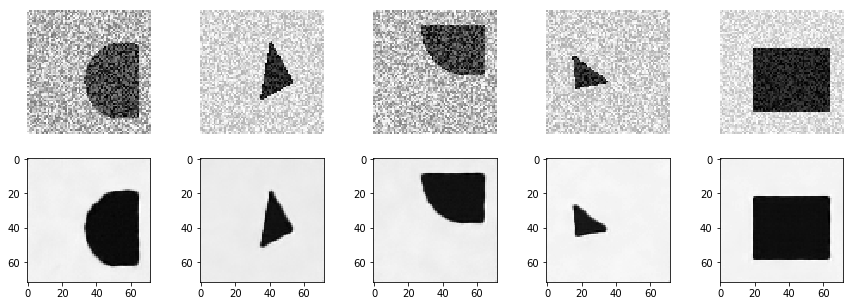

In [29]:
display_denoising(X_test7, Yt7pred,offset=10)

The results are pretty good but not perfect. The quality of the denoising tends to diminish when the amplitude of the noise increases.